In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import norm #Analysis 
from scipy import stats #Analysis 

import xgboost as xgb
import lightgbm as lgb

# Set a few plotting defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Colab Notebooks'	        images.zip  'My Drive'	 yolov3
'Copy of Train_YoloV3 .ipynb'   ML	     train	 yolov4


In [ ]:
!ls /mydrive/ML

 Blended2_Well_10.csv	  Final_Well_9.csv	     Well12.csv
 Blended2_Well_1.csv	 'KNN 1 - TESSST.ipynb'      Well13.csv
 Blended2_Well_2.csv	 'KNN 1 - Test.ipynb'	     Well14.csv
 Blended2_Well_3.csv	 'KNN 1 - Train.ipynb'	     Well15.csv
 Blended2_Well_4.csv	  knn_model1.pkl	     Well16.csv
 Blended2_Well_5.csv	  knn_model2.pkl	     Well17.csv
 Blended2_Well_6.csv	  knn_model4.pkl	     Well18.csv
 Blended2_Well_7.csv	  knn_model8.pkl	     Well19.csv
 Blended2_Well_8.csv	  knn_model.pkl		     Well1.csv
 Blended2_Well_9.csv	  knn_no_spr.pkl	     Well1.las
 Blended_Well_10.csv	  knn_scaler1.pkl	     well1_result.csv
 Blended_Well_1.csv	  knn_scaler2.pkl	    'Well 20.csv'
 Blended_Well_2.csv	  knn_scaler4.pkl	     Well2.csv
 Blended_Well_3.csv	  knn_scaler8.pkl	     Well2.las
 Blended_Well_4.csv	  knn_scaler.pkl	     well2_result.csv
 Blended_Well_5.csv	  LGBM.ipynb		     Well3.csv
 Blended_Well_6.csv	  ML-Challenge-Data.zip      Well3.las
 Blended_Well_7.csv	  NaN_Well_10.csv	     well3_re

In [ ]:
df = pd.read_csv('../content/gdrive/MyDrive/ML/challenge-new-data.csv')
df2 = pd.read_csv('../content/gdrive/MyDrive/ML/eed1e9537976_TGS.csv')

### Train Data ###

# combining GRR, GRS, and GRD into GR
df['GR'] = df['GRR']
df['GR'] = df['GR'].combine_first(df['GRS'])
df['GR'] = df['GR'].combine_first(df['GRD'])

# combining NPHI, NPHI_LS, TNPH, and TNPH_LS into PHIN
df['PHIN'] = df['NPHI']
df['PHIN'] = df['PHIN'].combine_first(df['NPHI_LS'])
df['PHIN'] = df['PHIN'].combine_first(df['TNPH'])
df['PHIN'] = df['PHIN'].combine_first(df['TNPH_LS'])

# combining DPHZ, DPHZ_LS, DPHI, and DPHI_LS into PHID
df['PHID'] = df['DPHZ']
df['PHID'] = df['PHID'].combine_first(df['DPHZ_LS'])
df['PHID'] = df['PHID'].combine_first(df['DPHI'])
df['PHID'] = df['PHID'].combine_first(df['DPHI_LS'])

# creating new dataframe with the combined logs 
cleanlogdata = df[['DTSM', 'DTCO', 'GR', 'PHIN', 'PHID', 'RHOZ', 'PEFZ', 'SPR']]

# removal of GR outlier (>200)
refinedGR = cleanlogdata[(cleanlogdata['GR']<200)]

# removal of PEFZ outlier (>5 ~ indicates barite contamination)
refinedPEFZ = refinedGR[(refinedGR['PEFZ']<5)]
refineddata = refinedPEFZ

data_dp = refineddata.dropna(subset=['DTSM'],axis=0, how='any')
train = data_dp[['DTSM','DTCO','GR','PHID','SPR','PEFZ','RHOZ']]


### Test Data ###

#available curves
available = df2.columns.tolist()

#curves we want
log_list = ['DTCO', 'GRR', 'GRS', 'GRD', 'NPHI','NPHI_LS','NPOR_LS','TNPH','TNPH_LS','DPHZ','DPHZ_LS','DPHI','DPHI_LS','DPO_LS','RHOZ','PEF','PEFL','PEFZ','SPR']

new_data = pd.DataFrame(columns=log_list)

for i in log_list:
  if i in available:
    new_data[[i]] = df2[[i]]
  else:
    new_data[[i]] = np.nan
new_data

#combine curves 
new_data['GR'] = new_data['GRD']
new_data['GR'] = new_data['GR'].combine_first(new_data['GRS']).combine_first(new_data['GRR'])
new_data = new_data.drop(columns=['GRR', 'GRS', 'GRD'])

new_data['PHIN'] = new_data['NPHI']
new_data['PHIN'] = new_data['PHIN'].combine_first(new_data['NPHI_LS']).combine_first(new_data['TNPH']).combine_first(new_data['TNPH_LS']).combine_first(new_data['NPOR_LS'])
new_data = new_data.drop(columns=['NPHI', 'NPHI_LS', 'TNPH', 'TNPH_LS','NPOR_LS'])

new_data['PHID'] = new_data['DPHZ']
new_data['PHID'] = new_data['PHID'].combine_first(new_data['DPHZ_LS']).combine_first(new_data['DPHI']).combine_first(new_data['DPHI_LS']).combine_first(new_data['DPO_LS'])
new_data = new_data.drop(columns=['DPHZ', 'DPHZ_LS', 'DPHI', 'DPHI_LS','DPO_LS'])

new_data['PEFZ'] = new_data['PEFZ'].combine_first(new_data['PEF']).combine_first(new_data['PEFL'])
new_data = new_data.drop(columns=['PEF','PEFL'])

# Test Data Variables
new_data = new_data[['DTCO','GR','PHID','SPR','PEFZ','RHOZ']]

test = new_data

In [ ]:
train = train.dropna(subset=['DTSM'])

In [ ]:
train.isnull().sum()

DTSM         0
DTCO     10091
GR           0
PHID     24595
SPR     212217
PEFZ         0
RHOZ     18646
dtype: int64

In [ ]:
#descriptive statistics summary
train['DTSM'].describe()

count    344730.000000
mean        120.753573
std          31.096581
min          21.645800
25%          99.516800
50%         114.322700
75%         134.920300
max         414.580100
Name: DTSM, dtype: float64

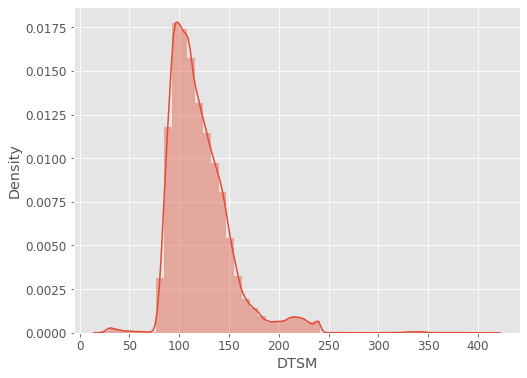

In [ ]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['DTSM'])

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % train['DTSM'].skew())
print("Kurtosis: %f" % train['DTSM'].kurt())

Skewness: 1.690593
Kurtosis: 5.806357


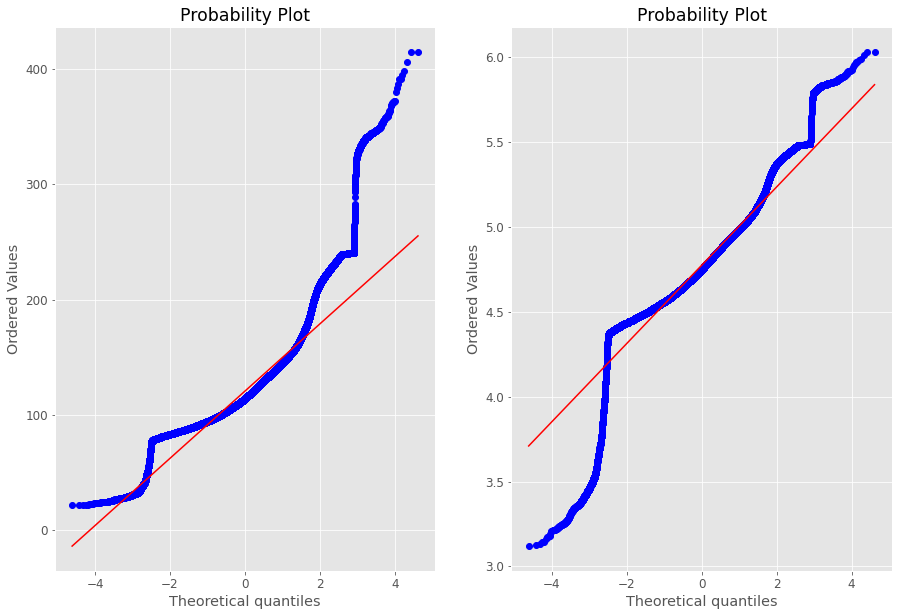

In [ ]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(train['DTSM'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train['DTSM']), plot=plt)

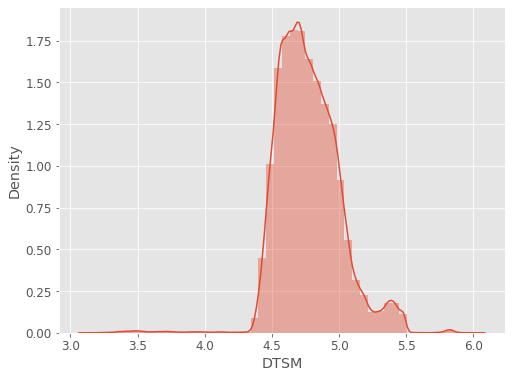

In [ ]:
train['DTSM'] = np.log1p(train['DTSM'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['DTSM'])

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % train['DTSM'].skew())
print("Kurtosis: %f" % train['DTSM'].kurt())

Skewness: 0.122027
Kurtosis: 3.646064


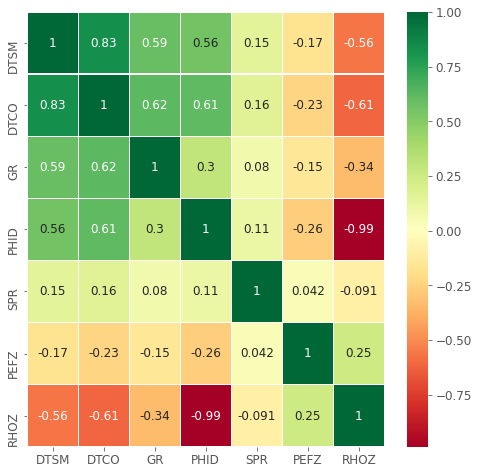

In [ ]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [ ]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import plotly.graph_objs as go

import time
import random

#https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-nn-approach
def mis_value_graph(data):  
    data = [
    go.Bar(
        x = data.columns,
        y = data.isnull().sum(),
        name = 'Counts of Missing value',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
    layout= go.Layout(
        title= '"Total Missing Value By Column"',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='skin')
    
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

df_all = pd.concat([train,test])
del df_all['DTSM']
mis_value_graph(df_all)

In [ ]:
### Number of Uniqueness
train_unique = []
columns = ['DTCO','GR','RHOZ','PHID','SPR','PEFZ']

for i in columns:
    train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
layout= go.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')

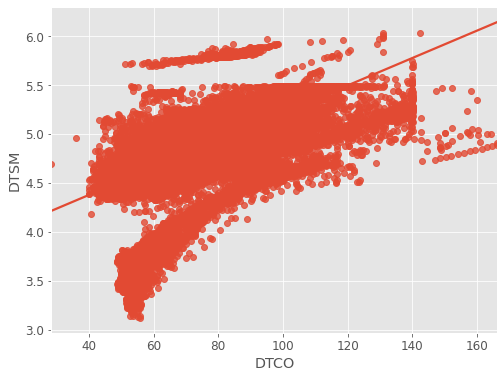

In [ ]:
data = pd.concat([train['DTSM'], train['DTCO']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='DTCO', y="DTSM", data=data)

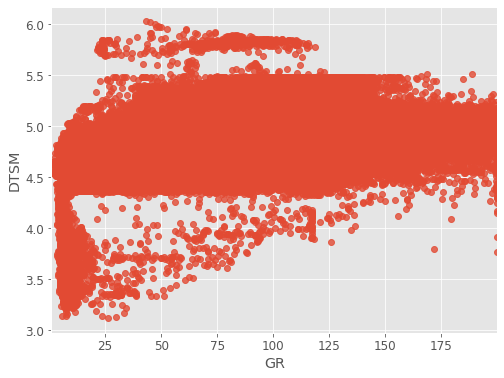

In [ ]:
data = pd.concat([train['DTSM'], train['GR']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='GR', y="DTSM", data=data)

In [ ]:
train = train.fillna(train.mean())

In [ ]:
y = train[['DTSM']].reset_index(drop=True)
train2 = train.drop('DTSM', axis = 1)
train2.shape

(344730, 6)

In [ ]:
all_df = pd.concat([train2, test]).reset_index(drop=True)
all_df.shape

(348687, 6)

In [ ]:
def check_na(data, head_num = 6):
  isnull_na = (data.isnull().sum() / len(data)) * 100
  data_na = isnull_na.drop(isnull_na[isnull_na == 0].index).sort_values(ascending=False)
  missing_data = pd.DataFrame({'Missing Ratio' :data_na, 
                               'Data Type': data.dtypes[data_na.index]})
  print("Missing Data (%):\n", missing_data.head(head_num))

check_na(all_df, 20)

Missing Data (%):
     Missing Ratio Data Type
GR        0.00803   float64


In [ ]:
print(train['DTCO'].value_counts())
print()
print(train['DTCO'].mode()[0])

68.563157    10091
61.184700       75
77.181400       59
50.110000       57
61.385500       55
             ...  
54.949800        1
83.702200        1
89.372400        1
91.671000        1
58.320400        1
Name: DTCO, Length: 234895, dtype: int64

68.56315659202889


In [ ]:
import numpy as np
num_all_vars = list(train2.select_dtypes(include=[np.number]))
print("The whole number of all_vars", len(num_all_vars))

print("The whole number of final_cat_vars", len(num_all_vars))
for i in num_all_vars:
  all_df[i].fillna(value=all_df[i].median(), inplace=True)

check_na(all_df, 20)

The whole number of all_vars 6
The whole number of final_cat_vars 6
Missing Data (%):
 Empty DataFrame
Columns: [Missing Ratio, Data Type]
Index: []


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344730 entries, 106778 to 3657168
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DTSM    344730 non-null  float64
 1   DTCO    344730 non-null  float64
 2   GR      344730 non-null  float64
 3   PHID    344730 non-null  float64
 4   SPR     344730 non-null  float64
 5   PEFZ    344730 non-null  float64
 6   RHOZ    344730 non-null  float64
dtypes: float64(7)
memory usage: 21.0 MB


In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in train2.columns if c not in ['DTSM']]

model = sm.OLS(train['DTSM'].values, train[train_columns])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.998e+07
Date:                Thu, 25 Feb 2021   Prob (F-statistic):                        0.00
Time:                        15:33:22   Log-Likelihood:                      1.6984e+05
No. Observations:              344730   AIC:                                 -3.397e+05
Df Residuals:                  344724   BIC:                                 -3.396e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = train.columns
vif["VIF Values"] = [variance_inflation_factor(
    train.values, i) for i in range(train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
0,DTSM,1044.889817
6,RHOZ,656.056584
1,DTCO,89.635829
5,PEFZ,34.118191
2,GR,7.824104
3,PHID,6.262992
4,SPR,1.993428


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = train['DTSM']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 30000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.09487	valid_1's rmse: 0.0949631
[1000]	training's rmse: 0.0905899	valid_1's rmse: 0.0918667
[1500]	training's rmse: 0.0881598	valid_1's rmse: 0.0903978
[2000]	training's rmse: 0.0863876	valid_1's rmse: 0.0894695
[2500]	training's rmse: 0.0849594	valid_1's rmse: 0.0887901
[3000]	training's rmse: 0.0837072	valid_1's rmse: 0.0882729
[3500]	training's rmse: 0.0826832	valid_1's rmse: 0.0878761
[4000]	training's rmse: 0.0817099	valid_1's rmse: 0.0875147
[4500]	training's rmse: 0.0808301	valid_1's rmse: 0.0872325
[5000]	training's rmse: 0.0800666	valid_1's rmse: 0.0870173
[5500]	training's rmse: 0.0793408	valid_1's rmse: 0.0868021
[6000]	training's rmse: 0.0786719	valid_1's rmse: 0.0866205
[6500]	training's rmse: 0.0780312	valid_1's rmse: 0.086463
[7000]	training's rmse: 0.0774202	valid_1's rmse: 0.08631
[7500]	training's rmse: 0.0768663	valid_1's rmse: 0.086197
[8000]	training's rmse: 0.0763189	valid_1's 

In [ ]:
cv1 = np.sqrt(mean_squared_error(oof, np.array(y_reg)))
print(cv1)

0.08628760045567528


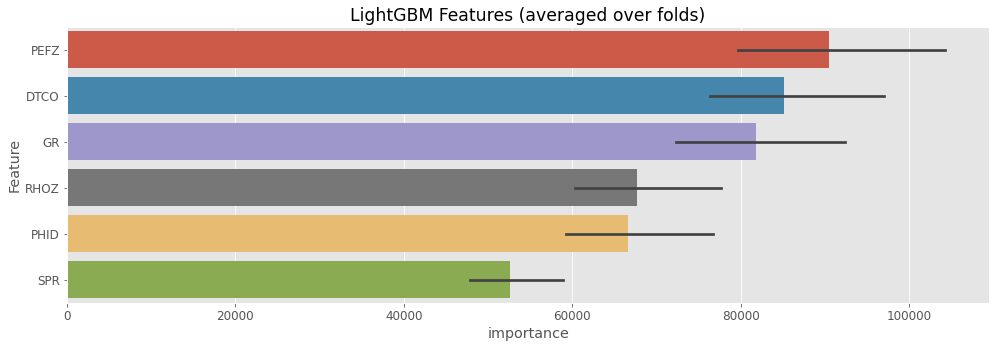

In [ ]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,5))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

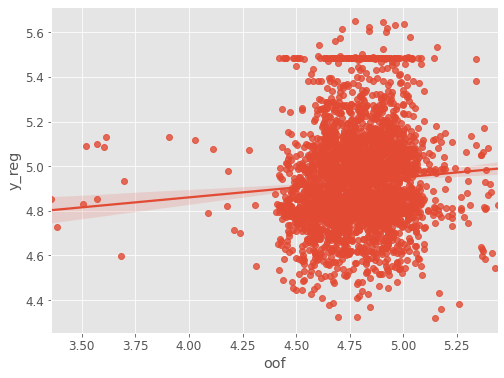

In [ ]:
df_oof = pd.DataFrame(oof)
df_y_reg = pd.DataFrame(y_reg)

data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='oof', y="y_reg", data=data)

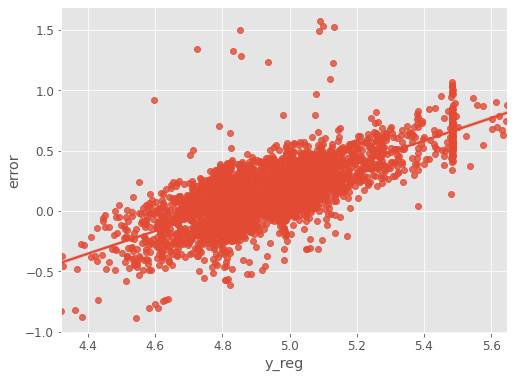

In [ ]:
data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
data['error'] = data['y_reg'] - data['oof']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='y_reg', y="error", data=data)

## Ensemble

In [ ]:
lgb1_oof = pd.DataFrame()
#lgb1_oof['id'] = df_train.id
lgb1_oof['DTSM'] = oof

lgb1_sub = pd.DataFrame()
#lgb1_sub['id'] = df_test.id
lgb1_sub['DTSM'] = predictions

cv1 = np.sqrt(mean_squared_error(oof, np.array(y_reg)))
print(cv1)

0.08628760045567528


In [ ]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(train[train_columns], log_y_reg)
dtest = xgb.DMatrix(test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=30000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

Transform DMatrix...
Start Cross Validation...
[0]	train-rmse:1.24051	test-rmse:1.24051
[500]	train-rmse:0.0193843	test-rmse:0.0196933
[1000]	train-rmse:0.01656	test-rmse:0.0171023
[1500]	train-rmse:0.016076	test-rmse:0.016825
[2000]	train-rmse:0.0157153	test-rmse:0.016664
[2500]	train-rmse:0.015419	test-rmse:0.0165547
[3000]	train-rmse:0.0151673	test-rmse:0.0164753
[3500]	train-rmse:0.0149437	test-rmse:0.016414
[4000]	train-rmse:0.0147413	test-rmse:0.016366
[4500]	train-rmse:0.0145583	test-rmse:0.016327
[5000]	train-rmse:0.014394	test-rmse:0.0162953
[5500]	train-rmse:0.0142307	test-rmse:0.016264
[6000]	train-rmse:0.014077	test-rmse:0.0162383
[6500]	train-rmse:0.0139333	test-rmse:0.0162157
[7000]	train-rmse:0.0137977	test-rmse:0.0161943
[7500]	train-rmse:0.0136647	test-rmse:0.0161737
[8000]	train-rmse:0.0135417	test-rmse:0.0161567
[8500]	train-rmse:0.0134193	test-rmse:0.0161413
[9000]	train-rmse:0.0133043	test-rmse:0.016129
[9500]	train-rmse:0.013191	test-rmse:0.0161157
[10000]	train-r

In [ ]:
preds2 = preds

In [ ]:
preds1 = np.expm1(lgb1_sub['DTSM'])

In [ ]:
pip install catboost

     |████████████████████████████████| 65.7MB 81kB/s 


In [ ]:
from catboost import CatBoostRegressor

# catboost model params
cat_params = {
    'n_estimators': 10000,
    'learning_rate': 0.07,
    #'eval_metric': 'TotalF1', # 'TotalF1'
    'eval_metric': 'RMSE',
    #'eval_metric': 'Logloss',
    'loss_function': 'Logloss',
    'random_seed': 42,
    'metric_period': 100,
    'od_wait': 100,
    'task_type': 'GPU',
    'depth': 6,
    #'bootstrap_type': 'Bayesian',
    'rsm': 0.8,
    #'colsample_bylevel': 0.7,
}


In [ ]:
model = CatBoostRegressor(iterations=60000, depth=6, learning_rate=0.01, metric_period=200,
                           eval_metric='RMSE', 
                           use_best_model=True,
                           random_seed=42)

model.fit(
    train2, y,
    # cat_features=categorical_features_indices,
    # verbose=True,  # you can uncomment this for text output
    # plot=True, # does not work for classifier
    eval_set=(train2, y)    
)

0:	learn: 0.2358973	test: 0.2358973	best: 0.2358973 (0)	total: 81.4ms	remaining: 1h 21m 22s
200:	learn: 0.1186471	test: 0.1186471	best: 0.1186471 (200)	total: 5.5s	remaining: 27m 17s
400:	learn: 0.1081433	test: 0.1081433	best: 0.1081433 (400)	total: 10.8s	remaining: 26m 42s
600:	learn: 0.1046523	test: 0.1046523	best: 0.1046523 (600)	total: 15.9s	remaining: 26m 14s
800:	learn: 0.1020983	test: 0.1020983	best: 0.1020983 (800)	total: 21.1s	remaining: 26m 1s
1000:	learn: 0.1005099	test: 0.1005099	best: 0.1005099 (1000)	total: 26.4s	remaining: 25m 53s
1200:	learn: 0.0992719	test: 0.0992719	best: 0.0992719 (1200)	total: 31.6s	remaining: 25m 48s
1400:	learn: 0.0982868	test: 0.0982868	best: 0.0982868 (1400)	total: 36.9s	remaining: 25m 42s
1600:	learn: 0.0974993	test: 0.0974993	best: 0.0974993 (1600)	total: 42.1s	remaining: 25m 34s
1800:	learn: 0.0967813	test: 0.0967813	best: 0.0967813 (1800)	total: 47.2s	remaining: 25m 26s
2000:	learn: 0.0961540	test: 0.0961540	best: 0.0961540 (2000)	total: 52.

In [ ]:
temp3 = model.predict(test)
preds3 = np.expm1(temp3)
preds2 = np.expm1(preds2)

In [ ]:
preds2

array([127.58722, 133.0851 , 133.8231 , ..., 169.71721, 171.26114,
       173.59357], dtype=float32)

In [ ]:
preds22 = np.expm1(preds2)

In [ ]:
ensemble_sub1 = pd.DataFrame(preds1)
ensemble_sub2 = pd.DataFrame(preds2)
ensemble_sub3 = pd.DataFrame(preds3)

In [ ]:
ensemble_sub = pd.concat([ensemble_sub1, ensemble_sub2, ensemble_sub3], axis=1)
ensemble_sub.columns = ['lgb','xgb','cgb']
ensemble_sub['DTSM'] = 0.4*ensemble_sub['lgb'] + 0.4*ensemble_sub['xgb'] + 0.2*ensemble_sub['cgb']
ensemble_sub = ensemble_sub['DTSM']
ensemble_sub.to_csv("../content/gdrive/MyDrive/ML/Final_Well_18.csv", index=False)

In [ ]:
ensemble_sub

0       128.778795
1       132.931481
2       132.791870
3       129.718305
4       123.336309
5       116.382182
6       113.336237
7       113.289479
8       110.573793
9       109.924772
10      105.694147
11       98.662716
12       98.587927
13      101.074572
14      104.229722
15      106.174315
16      108.417403
17      110.347301
18      109.277081
19      107.611243
20      105.781559
21      102.546348
22      101.411893
23      100.806472
24      101.996591
25      100.629154
26       98.947915
27       98.121033
28      101.801129
29      105.125790
30      108.291580
31      110.536224
32      114.338402
33      121.708741
34      126.497620
35      124.091113
36      121.401122
37      115.804590
38      108.853935
39      108.683853
40      111.546175
41      112.756699
42      113.954678
43      117.506040
44      118.473193
45      118.941232
46      122.671313
47      124.416358
48      125.055708
49      125.347879
50      123.573236
51      118.743537
52      119.